# Overview of this jupyter notebook

1. Loading the data
2. Hyperparameter optimization for GradientBoost Model
3. Evaluation of the optimized model and saving the results

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 60)
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from skmultilearn.problem_transform import BinaryRelevance
from tqdm.notebook import tqdm_notebook as tq
from warnings import filterwarnings
filterwarnings('ignore')
import pickle
import json
import random

In [2]:
import os
import importlib
from library import etl_data as etl            # this module contains functions that load, visualize and save the data
from library import faps_color as fapsc        # this module contains the color combination of FAPS Institute
from library import classification_helper as ch  # this module contains helper functions for the classification task
print(importlib.reload(etl))
print(importlib.reload(fapsc))
print(importlib.reload(ch))

<module 'library.etl_data' from 'D:\\MA_Songsik_Shin\\04_Code\\library\\etl_data.py'>
<module 'library.faps_color' from 'D:\\MA_Songsik_Shin\\04_Code\\library\\faps_color.py'>
<module 'library.classification_helper' from 'D:\\MA_Songsik_Shin\\04_Code\\library\\classification_helper.py'>


In [3]:
!python -V

Python 3.10.6


# 1. Loading the data

In [7]:
classes = ['0_in_ordnung',
           '1_kleine_durchgangsbohrung',
           '2_versetzte_fuegepartner',
           '3_unebene_fuegeflaeche',
           '4_span_im_gewinde',
           '5_verschmutzte_schraube',
           '6_fremdkoerper_am_gewindeende',
           '7_beschaedigte_schraube']

In [8]:
feature_train = pd.read_pickle("feature_label/mlc_feature_train_tsfresh_2.4.pkl")
feature_train.shape

(1550, 789)

In [9]:
feature_test = pd.read_pickle("feature_label/mlc_feature_test_tsfresh_2.4.pkl")
feature_test.shape

(750, 789)

In [10]:
label_train = pd.read_pickle("feature_label/mlc_label_train_tsfresh_v2.4.pkl")
label_train.shape

(1550, 8)

In [11]:
label_test = pd.read_pickle("feature_label/mlc_label_test_tsfresh_v2.4.pkl")
label_test.shape

(750, 8)

In [12]:
relevance_table = pd.read_pickle("feature_label/mlc_relevance_table_tsfresh_v2.4.pkl")
relevance_table

,feature,type,p_value_0,relevant_0,p_value_1,relevant_1,p_value_2,relevant_2,p_value_3,relevant_3,p_value_4,relevant_4,p_value_5,relevant_5,p_value_6,relevant_6,p_value_7,relevant_7,p_value_8,relevant_8,p_value_9,relevant_9,p_value_10,relevant_10,p_value_11,relevant_11,p_value_12,relevant_12,p_value_13,relevant_13,p_value_14,relevant_14,n_significant,relevant
feature,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
torque__variation_coefficient,torque__variation_coefficient,real,5.197543e-90,True,1.643083e-07,True,5.144671e-13,True,6.022008e-41,True,2.678407e-11,True,3.459922e-02,False,2.137971e-29,True,6.742358e-25,True,5.705008e-03,False,3.158111e-14,True,1.457102e-25,True,1.597761e-07,True,0.029758,False,1.769481e-17,True,0.002942,False,11,True
torque__lempel_ziv_complexity__bins_100,torque__lempel_ziv_complexity__bins_100,real,5.463394e-90,True,9.139738e-09,True,1.787593e-16,True,2.365570e-50,True,2.081732e-21,True,5.843446e-19,True,3.908102e-07,True,4.137441e-09,True,1.990712e-16,True,2.544483e-12,True,4.183211e-17,True,4.656514e-06,True,0.072377,False,1.791119e-30,True,0.000034,True,14,True
torque__mean,torque__mean,real,9.576607e-90,True,2.213726e-06,True,2.304176e-11,True,6.607692e-39,True,3.657118e-13,True,4.674008e-03,False,4.020447e-35,True,1.552304e-34,True,4.396053e-02,False,5.792276e-13,True,9.756297e-24,True,4.440944e-07,True,0.000483,True,7.502963e-16,True,0.000886,True,13,True
"torque__fft_coefficient__attr_""abs""__coeff_0","torque__fft_coefficient__attr_""abs""__coeff_0",real,9.576613e-90,True,2.214774e-06,True,2.302666e-11,True,6.591071e-39,True,3.654522e-13,True,4.669805e-03,False,4.015649e-35,True,1.552305e-34,True,4.392685e-02,False,5.792276e-13,True,9.724570e-24,True,4.452156e-07,True,0.000483,True,7.512830e-16,True,0.000887,True,13,True
"torque__fft_coefficient__attr_""real""__coeff_0","torque__fft_coefficient__attr_""real""__coeff_0",real,9.576613e-90,True,2.214774e-06,True,2.302666e-11,True,6.591071e-39,True,3.654522e-13,True,4.669805e-03,False,4.015649e-35,True,1.552305e-34,True,4.392685e-02,False,5.792276e-13,True,9.724570e-24,True,4.452156e-07,True,0.000483,True,7.512830e-16,True,0.000887,True,13,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
torque__friedrich_coefficients__coeff_3__m_3__r_30,torque__friedrich_coefficients__coeff_3__m_3__...,constant,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,0,False
torque__max_langevin_fixed_point__m_3__r_30,torque__max_langevin_fixed_point__m_3__r_30,constant,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,0,False
torque__number_crossing_m__m_-1,torque__number_crossing_m__m_-1,constant,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,0,False


In [13]:
relevance_table = relevance_table[relevance_table.relevant==True]
relevance_table

,feature,type,p_value_0,relevant_0,p_value_1,relevant_1,p_value_2,relevant_2,p_value_3,relevant_3,p_value_4,relevant_4,p_value_5,relevant_5,p_value_6,relevant_6,p_value_7,relevant_7,p_value_8,relevant_8,p_value_9,relevant_9,p_value_10,relevant_10,p_value_11,relevant_11,p_value_12,relevant_12,p_value_13,relevant_13,p_value_14,relevant_14,n_significant,relevant
feature,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
torque__variation_coefficient,torque__variation_coefficient,real,5.197543e-90,True,1.643083e-07,True,5.144671e-13,True,6.022008e-41,True,2.678407e-11,True,3.459922e-02,False,2.137971e-29,True,6.742358e-25,True,5.705008e-03,False,3.158111e-14,True,1.457102e-25,True,1.597761e-07,True,0.029758,False,1.769481e-17,True,0.002942,False,11,True
torque__lempel_ziv_complexity__bins_100,torque__lempel_ziv_complexity__bins_100,real,5.463394e-90,True,9.139738e-09,True,1.787593e-16,True,2.365570e-50,True,2.081732e-21,True,5.843446e-19,True,3.908102e-07,True,4.137441e-09,True,1.990712e-16,True,2.544483e-12,True,4.183211e-17,True,4.656514e-06,True,0.072377,False,1.791119e-30,True,0.000034,True,14,True
torque__mean,torque__mean,real,9.576607e-90,True,2.213726e-06,True,2.304176e-11,True,6.607692e-39,True,3.657118e-13,True,4.674008e-03,False,4.020447e-35,True,1.552304e-34,True,4.396053e-02,False,5.792276e-13,True,9.756297e-24,True,4.440944e-07,True,0.000483,True,7.502963e-16,True,0.000886,True,13,True
"torque__fft_coefficient__attr_""abs""__coeff_0","torque__fft_coefficient__attr_""abs""__coeff_0",real,9.576613e-90,True,2.214774e-06,True,2.302666e-11,True,6.591071e-39,True,3.654522e-13,True,4.669805e-03,False,4.015649e-35,True,1.552305e-34,True,4.392685e-02,False,5.792276e-13,True,9.724570e-24,True,4.452156e-07,True,0.000483,True,7.512830e-16,True,0.000887,True,13,True
"torque__fft_coefficient__attr_""real""__coeff_0","torque__fft_coefficient__attr_""real""__coeff_0",real,9.576613e-90,True,2.214774e-06,True,2.302666e-11,True,6.591071e-39,True,3.654522e-13,True,4.669805e-03,False,4.015649e-35,True,1.552305e-34,True,4.392685e-02,False,5.792276e-13,True,9.724570e-24,True,4.452156e-07,True,0.000483,True,7.512830e-16,True,0.000887,True,13,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"torque__fft_coefficient__attr_""imag""__coeff_92","torque__fft_coefficient__attr_""imag""__coeff_92",real,9.478897e-01,False,1.716470e-01,False,9.849157e-01,False,1.072699e-04,True,8.559883e-01,False,5.015247e-01,False,1.822312e-01,False,4.250886e-01,False,4.911643e-01,False,1.170838e-02,False,1.711853e-01,False,8.991722e-01,False,0.025441,False,7.237413e-01,False,0.292634,False,1,True
"torque__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20)",torque__cwt_coefficients__coeff_12__w_2__width...,real,9.544628e-01,False,2.995364e-12,True,1.424985e-01,False,3.158056e-02,False,4.182010e-03,False,5.572269e-01,False,1.291619e-01,False,2.636988e-01,False,2.499537e-07,True,2.074936e-01,False,6.579449e-01,False,8.661737e-02,False,0.083162,False,6.838159e-01,False,0.142855,False,2,True
"torque__fft_coefficient__attr_""real""__coeff_91","torque__fft_coefficient__attr_""real""__coeff_91",real,9.748111e-01,False,1.528592e-01,False,9.135638e-01,False,2.650780e-05,True,9.138683e-01,False,6.113325e-01,False,5.596143e-01,False,2.779372e-01,False,4.141510e-01,False,1.277503e-02,False,1.527884e-01,False,7.170111e-01,False,0.003934,False,5.555035e-01,False,0.163287,False,1,True


In [16]:
relevant_feature = list(relevance_table[relevance_table.relevant==True].feature)
len(relevant_feature)

615

In [17]:
feat_train = feature_train[relevant_feature]
feat_test = feature_test[relevant_feature]
feat_train.shape, feat_test.shape

((1550, 615), (750, 615))

In [18]:
lab_train = label_train.values
lab_test = label_test.values
lab_train.shape, lab_test.shape

((1550, 8), (750, 8))

In [19]:
from sklearn.utils import shuffle

x_train, y_train = shuffle(feat_train, lab_train, random_state=9)
x_test, y_test = shuffle(feat_test, lab_test, random_state=9)

y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
y_test

array([[0, 0, 1, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [20]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1550, 615), (1550, 8), (750, 615), (750, 8))

# 2. Hyperparameter optimization for GradientBoost Model

In [18]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
parameters={'classifier__criterion':['squared_error', 'mse'], 'classifier__learning_rate':[0.01, 0.05, 0.1],
            'classifier__n_estimators':[100,150,200], 'classifier__max_depth':[20,80,200], 
            'classifier__min_samples_split': [2,4,8], 'classifier__max_features':['sqrt', 'log2'], }

search = GridSearchCV(BinaryRelevance(classifier=GradientBoostingClassifier()), 
                      parameters, cv=5, scoring='accuracy', verbose=10)
search.fit(x_train, y_train)
print(search.best_score_, search.best_params_)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV 1/5; 1/324] START classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_split=2, classifier__n_estimators=100
[CV 1/5; 1/324] END classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.671 total time=  19.7s
[CV 2/5; 1/324] START classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_split=2, classifier__n_estimators=100
[CV 2/5; 1/324] END classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.739 total time=  20.8s
[CV 3/5; 1/324] START classifier__

[CV 4/5; 4/324] END classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.752 total time=  48.8s
[CV 5/5; 4/324] START classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_split=4, classifier__n_estimators=100
[CV 5/5; 4/324] END classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.723 total time=  47.3s
[CV 1/5; 5/324] START classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_split=4, classifier__n_estimators=150
[CV 1/5; 5/324] END classifier__criterion=squared_error, classifier__learning_rate=0.01, classifie

[CV 3/5; 8/324] END classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_split=8, classifier__n_estimators=150;, score=0.813 total time= 1.2min
[CV 4/5; 8/324] START classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_split=8, classifier__n_estimators=150
[CV 4/5; 8/324] END classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_split=8, classifier__n_estimators=150;, score=0.806 total time= 1.2min
[CV 5/5; 8/324] START classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_split=8, classifier__n_estimators=150
[CV 5/5; 8/324] END classifier__criterion=squared_error, classifier__learning_rate=0.01, classifie

[CV 2/5; 12/324] END classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__max_features=log2, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.794 total time=  21.6s
[CV 3/5; 12/324] START classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__max_features=log2, classifier__min_samples_split=2, classifier__n_estimators=200
[CV 3/5; 12/324] END classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__max_features=log2, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.806 total time=  21.7s
[CV 4/5; 12/324] START classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__max_features=log2, classifier__min_samples_split=2, classifier__n_estimators=200
[CV 4/5; 12/324] END classifier__criterion=squared_error, classifier__learning_rate=0.01, clas

[CV 1/5; 16/324] END classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__max_features=log2, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.661 total time=  24.7s
[CV 2/5; 16/324] START classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__max_features=log2, classifier__min_samples_split=8, classifier__n_estimators=100
[CV 2/5; 16/324] END classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__max_features=log2, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.706 total time=  24.5s
[CV 3/5; 16/324] START classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=20, classifier__max_features=log2, classifier__min_samples_split=8, classifier__n_estimators=100
[CV 3/5; 16/324] END classifier__criterion=squared_error, classifier__learning_rate=0.01, clas

[CV 5/5; 19/324] END classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.726 total time=  20.6s
[CV 1/5; 20/324] START classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_samples_split=2, classifier__n_estimators=150
[CV 1/5; 20/324] END classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_samples_split=2, classifier__n_estimators=150;, score=0.765 total time=  29.1s
[CV 2/5; 20/324] START classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_samples_split=2, classifier__n_estimators=150
[CV 2/5; 20/324] END classifier__criterion=squared_error, classifier__learning_rate=0.01, clas

[CV 4/5; 23/324] END classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_samples_split=4, classifier__n_estimators=150;, score=0.800 total time= 2.0min
[CV 5/5; 23/324] START classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_samples_split=4, classifier__n_estimators=150
[CV 5/5; 23/324] END classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_samples_split=4, classifier__n_estimators=150;, score=0.787 total time= 2.0min
[CV 1/5; 24/324] START classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_samples_split=4, classifier__n_estimators=200
[CV 1/5; 24/324] END classifier__criterion=squared_error, classifier__learning_rate=0.01, clas

[CV 3/5; 27/324] END classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.839 total time= 2.8min
[CV 4/5; 27/324] START classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_samples_split=8, classifier__n_estimators=200
[CV 4/5; 27/324] END classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.826 total time= 2.7min
[CV 5/5; 27/324] START classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_samples_split=8, classifier__n_estimators=200
[CV 5/5; 27/324] END classifier__criterion=squared_error, classifier__learning_rate=0.01, clas

[CV 2/5; 31/324] END classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=80, classifier__max_features=log2, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.697 total time=  33.8s
[CV 3/5; 31/324] START classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=80, classifier__max_features=log2, classifier__min_samples_split=4, classifier__n_estimators=100
[CV 3/5; 31/324] END classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=80, classifier__max_features=log2, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.697 total time=  34.7s
[CV 4/5; 31/324] START classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=80, classifier__max_features=log2, classifier__min_samples_split=4, classifier__n_estimators=100
[CV 4/5; 31/324] END classifier__criterion=squared_error, classifier__learning_rate=0.01, clas

[CV 1/5; 35/324] END classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=80, classifier__max_features=log2, classifier__min_samples_split=8, classifier__n_estimators=150;, score=0.745 total time=  48.4s
[CV 2/5; 35/324] START classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=80, classifier__max_features=log2, classifier__min_samples_split=8, classifier__n_estimators=150
[CV 2/5; 35/324] END classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=80, classifier__max_features=log2, classifier__min_samples_split=8, classifier__n_estimators=150;, score=0.790 total time=  48.1s
[CV 3/5; 35/324] START classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=80, classifier__max_features=log2, classifier__min_samples_split=8, classifier__n_estimators=150
[CV 3/5; 35/324] END classifier__criterion=squared_error, classifier__learning_rate=0.01, clas

[CV 5/5; 38/324] END classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_samples_split=2, classifier__n_estimators=150;, score=0.781 total time=  29.4s
[CV 1/5; 39/324] START classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_samples_split=2, classifier__n_estimators=200
[CV 1/5; 39/324] END classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.803 total time=  37.3s
[CV 2/5; 39/324] START classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_samples_split=2, classifier__n_estimators=200
[CV 2/5; 39/324] END classifier__criterion=squared_error, classifier__learning_rate=0.01, 

[CV 4/5; 42/324] END classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.816 total time= 2.7min
[CV 5/5; 42/324] START classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_samples_split=4, classifier__n_estimators=200
[CV 5/5; 42/324] END classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.826 total time= 2.8min
[CV 1/5; 43/324] START classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_samples_split=8, classifier__n_estimators=100
[CV 1/5; 43/324] END classifier__criterion=squared_error, classifier__learning_rate=0.01, 

[CV 3/5; 46/324] END classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=200, classifier__max_features=log2, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.700 total time=   9.6s
[CV 4/5; 46/324] START classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=200, classifier__max_features=log2, classifier__min_samples_split=2, classifier__n_estimators=100
[CV 4/5; 46/324] END classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=200, classifier__max_features=log2, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.710 total time=   9.8s
[CV 5/5; 46/324] START classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=200, classifier__max_features=log2, classifier__min_samples_split=2, classifier__n_estimators=100
[CV 5/5; 46/324] END classifier__criterion=squared_error, classifier__learning_rate=0.01, 

[CV 2/5; 50/324] END classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=200, classifier__max_features=log2, classifier__min_samples_split=4, classifier__n_estimators=150;, score=0.774 total time=  56.2s
[CV 3/5; 50/324] START classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=200, classifier__max_features=log2, classifier__min_samples_split=4, classifier__n_estimators=150
[CV 3/5; 50/324] END classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=200, classifier__max_features=log2, classifier__min_samples_split=4, classifier__n_estimators=150;, score=0.810 total time=  55.5s
[CV 4/5; 50/324] START classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=200, classifier__max_features=log2, classifier__min_samples_split=4, classifier__n_estimators=150
[CV 4/5; 50/324] END classifier__criterion=squared_error, classifier__learning_rate=0.01, 

[CV 1/5; 54/324] END classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=200, classifier__max_features=log2, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.797 total time= 1.1min
[CV 2/5; 54/324] START classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=200, classifier__max_features=log2, classifier__min_samples_split=8, classifier__n_estimators=200
[CV 2/5; 54/324] END classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=200, classifier__max_features=log2, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.813 total time= 1.1min
[CV 3/5; 54/324] START classifier__criterion=squared_error, classifier__learning_rate=0.01, classifier__max_depth=200, classifier__max_features=log2, classifier__min_samples_split=8, classifier__n_estimators=200
[CV 3/5; 54/324] END classifier__criterion=squared_error, classifier__learning_rate=0.01, 

[CV 5/5; 57/324] END classifier__criterion=squared_error, classifier__learning_rate=0.05, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.852 total time=  37.8s
[CV 1/5; 58/324] START classifier__criterion=squared_error, classifier__learning_rate=0.05, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_split=4, classifier__n_estimators=100
[CV 1/5; 58/324] END classifier__criterion=squared_error, classifier__learning_rate=0.05, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.858 total time=  48.8s
[CV 2/5; 58/324] START classifier__criterion=squared_error, classifier__learning_rate=0.05, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_split=4, classifier__n_estimators=100
[CV 2/5; 58/324] END classifier__criterion=squared_error, classifier__learning_rate=0.05, clas

[CV 4/5; 61/324] END classifier__criterion=squared_error, classifier__learning_rate=0.05, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.858 total time=  47.2s
[CV 5/5; 61/324] START classifier__criterion=squared_error, classifier__learning_rate=0.05, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_split=8, classifier__n_estimators=100
[CV 5/5; 61/324] END classifier__criterion=squared_error, classifier__learning_rate=0.05, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.832 total time=  46.8s
[CV 1/5; 62/324] START classifier__criterion=squared_error, classifier__learning_rate=0.05, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_split=8, classifier__n_estimators=150
[CV 1/5; 62/324] END classifier__criterion=squared_error, classifier__learning_rate=0.05, clas

[CV 3/5; 65/324] END classifier__criterion=squared_error, classifier__learning_rate=0.05, classifier__max_depth=20, classifier__max_features=log2, classifier__min_samples_split=2, classifier__n_estimators=150;, score=0.855 total time=  14.7s
[CV 4/5; 65/324] START classifier__criterion=squared_error, classifier__learning_rate=0.05, classifier__max_depth=20, classifier__max_features=log2, classifier__min_samples_split=2, classifier__n_estimators=150
[CV 4/5; 65/324] END classifier__criterion=squared_error, classifier__learning_rate=0.05, classifier__max_depth=20, classifier__max_features=log2, classifier__min_samples_split=2, classifier__n_estimators=150;, score=0.848 total time=  14.9s
[CV 5/5; 65/324] START classifier__criterion=squared_error, classifier__learning_rate=0.05, classifier__max_depth=20, classifier__max_features=log2, classifier__min_samples_split=2, classifier__n_estimators=150
[CV 5/5; 65/324] END classifier__criterion=squared_error, classifier__learning_rate=0.05, clas

[CV 2/5; 69/324] END classifier__criterion=squared_error, classifier__learning_rate=0.05, classifier__max_depth=20, classifier__max_features=log2, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.835 total time=  49.2s
[CV 3/5; 69/324] START classifier__criterion=squared_error, classifier__learning_rate=0.05, classifier__max_depth=20, classifier__max_features=log2, classifier__min_samples_split=4, classifier__n_estimators=200
[CV 3/5; 69/324] END classifier__criterion=squared_error, classifier__learning_rate=0.05, classifier__max_depth=20, classifier__max_features=log2, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.865 total time=  50.1s
[CV 4/5; 69/324] START classifier__criterion=squared_error, classifier__learning_rate=0.05, classifier__max_depth=20, classifier__max_features=log2, classifier__min_samples_split=4, classifier__n_estimators=200
[CV 4/5; 69/324] END classifier__criterion=squared_error, classifier__learning_rate=0.05, clas

[CV 1/5; 73/324] END classifier__criterion=squared_error, classifier__learning_rate=0.05, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.848 total time=  16.6s
[CV 2/5; 73/324] START classifier__criterion=squared_error, classifier__learning_rate=0.05, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_samples_split=2, classifier__n_estimators=100
[CV 2/5; 73/324] END classifier__criterion=squared_error, classifier__learning_rate=0.05, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.832 total time=  16.4s
[CV 3/5; 73/324] START classifier__criterion=squared_error, classifier__learning_rate=0.05, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_samples_split=2, classifier__n_estimators=100
[CV 3/5; 73/324] END classifier__criterion=squared_error, classifier__learning_rate=0.05, clas

[CV 5/5; 76/324] END classifier__criterion=squared_error, classifier__learning_rate=0.05, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.852 total time= 1.1min
[CV 1/5; 77/324] START classifier__criterion=squared_error, classifier__learning_rate=0.05, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_samples_split=4, classifier__n_estimators=150
[CV 1/5; 77/324] END classifier__criterion=squared_error, classifier__learning_rate=0.05, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_samples_split=4, classifier__n_estimators=150;, score=0.858 total time= 1.6min
[CV 2/5; 77/324] START classifier__criterion=squared_error, classifier__learning_rate=0.05, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_samples_split=4, classifier__n_estimators=150
[CV 2/5; 77/324] END classifier__criterion=squared_error, classifier__learning_rate=0.05, clas

[CV 4/5; 80/324] END classifier__criterion=squared_error, classifier__learning_rate=0.05, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_samples_split=8, classifier__n_estimators=150;, score=0.877 total time= 1.9min
[CV 5/5; 80/324] START classifier__criterion=squared_error, classifier__learning_rate=0.05, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_samples_split=8, classifier__n_estimators=150
[CV 5/5; 80/324] END classifier__criterion=squared_error, classifier__learning_rate=0.05, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_samples_split=8, classifier__n_estimators=150;, score=0.865 total time= 1.8min
[CV 1/5; 81/324] START classifier__criterion=squared_error, classifier__learning_rate=0.05, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_samples_split=8, classifier__n_estimators=200
[CV 1/5; 81/324] END classifier__criterion=squared_error, classifier__learning_rate=0.05, clas

[CV 3/5; 84/324] END classifier__criterion=squared_error, classifier__learning_rate=0.05, classifier__max_depth=80, classifier__max_features=log2, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.861 total time=  18.4s
[CV 4/5; 84/324] START classifier__criterion=squared_error, classifier__learning_rate=0.05, classifier__max_depth=80, classifier__max_features=log2, classifier__min_samples_split=2, classifier__n_estimators=200
[CV 4/5; 84/324] END classifier__criterion=squared_error, classifier__learning_rate=0.05, classifier__max_depth=80, classifier__max_features=log2, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.861 total time=  18.2s
[CV 5/5; 84/324] START classifier__criterion=squared_error, classifier__learning_rate=0.05, classifier__max_depth=80, classifier__max_features=log2, classifier__min_samples_split=2, classifier__n_estimators=200
[CV 5/5; 84/324] END classifier__criterion=squared_error, classifier__learning_rate=0.05, clas

[CV 2/5; 88/324] END classifier__criterion=squared_error, classifier__learning_rate=0.05, classifier__max_depth=80, classifier__max_features=log2, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.839 total time=  34.4s
[CV 3/5; 88/324] START classifier__criterion=squared_error, classifier__learning_rate=0.05, classifier__max_depth=80, classifier__max_features=log2, classifier__min_samples_split=8, classifier__n_estimators=100
[CV 3/5; 88/324] END classifier__criterion=squared_error, classifier__learning_rate=0.05, classifier__max_depth=80, classifier__max_features=log2, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.855 total time=  34.8s
[CV 4/5; 88/324] START classifier__criterion=squared_error, classifier__learning_rate=0.05, classifier__max_depth=80, classifier__max_features=log2, classifier__min_samples_split=8, classifier__n_estimators=100
[CV 4/5; 88/324] END classifier__criterion=squared_error, classifier__learning_rate=0.05, clas

[CV 1/5; 92/324] END classifier__criterion=squared_error, classifier__learning_rate=0.05, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_samples_split=2, classifier__n_estimators=150;, score=0.865 total time=  27.7s
[CV 2/5; 92/324] START classifier__criterion=squared_error, classifier__learning_rate=0.05, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_samples_split=2, classifier__n_estimators=150
[CV 2/5; 92/324] END classifier__criterion=squared_error, classifier__learning_rate=0.05, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_samples_split=2, classifier__n_estimators=150;, score=0.835 total time=  27.2s
[CV 3/5; 92/324] START classifier__criterion=squared_error, classifier__learning_rate=0.05, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_samples_split=2, classifier__n_estimators=150
[CV 3/5; 92/324] END classifier__criterion=squared_error, classifier__learning_rate=0.05, 

[CV 5/5; 95/324] END classifier__criterion=squared_error, classifier__learning_rate=0.05, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_samples_split=4, classifier__n_estimators=150;, score=0.855 total time= 1.8min
[CV 1/5; 96/324] START classifier__criterion=squared_error, classifier__learning_rate=0.05, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_samples_split=4, classifier__n_estimators=200
[CV 1/5; 96/324] END classifier__criterion=squared_error, classifier__learning_rate=0.05, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.868 total time= 2.3min
[CV 2/5; 96/324] START classifier__criterion=squared_error, classifier__learning_rate=0.05, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_samples_split=4, classifier__n_estimators=200
[CV 2/5; 96/324] END classifier__criterion=squared_error, classifier__learning_rate=0.05, 

[CV 4/5; 99/324] END classifier__criterion=squared_error, classifier__learning_rate=0.05, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.871 total time= 2.7min
[CV 5/5; 99/324] START classifier__criterion=squared_error, classifier__learning_rate=0.05, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_samples_split=8, classifier__n_estimators=200
[CV 5/5; 99/324] END classifier__criterion=squared_error, classifier__learning_rate=0.05, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.865 total time= 2.7min
[CV 1/5; 100/324] START classifier__criterion=squared_error, classifier__learning_rate=0.05, classifier__max_depth=200, classifier__max_features=log2, classifier__min_samples_split=2, classifier__n_estimators=100
[CV 1/5; 100/324] END classifier__criterion=squared_error, classifier__learning_rate=0.05

[CV 2/5; 103/324] END classifier__criterion=squared_error, classifier__learning_rate=0.05, classifier__max_depth=200, classifier__max_features=log2, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.819 total time=  35.9s
[CV 3/5; 103/324] START classifier__criterion=squared_error, classifier__learning_rate=0.05, classifier__max_depth=200, classifier__max_features=log2, classifier__min_samples_split=4, classifier__n_estimators=100
[CV 3/5; 103/324] END classifier__criterion=squared_error, classifier__learning_rate=0.05, classifier__max_depth=200, classifier__max_features=log2, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.855 total time=  37.0s
[CV 4/5; 103/324] START classifier__criterion=squared_error, classifier__learning_rate=0.05, classifier__max_depth=200, classifier__max_features=log2, classifier__min_samples_split=4, classifier__n_estimators=100
[CV 4/5; 103/324] END classifier__criterion=squared_error, classifier__learning_rate=0

[CV 5/5; 106/324] END classifier__criterion=squared_error, classifier__learning_rate=0.05, classifier__max_depth=200, classifier__max_features=log2, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.858 total time=  34.3s
[CV 1/5; 107/324] START classifier__criterion=squared_error, classifier__learning_rate=0.05, classifier__max_depth=200, classifier__max_features=log2, classifier__min_samples_split=8, classifier__n_estimators=150
[CV 1/5; 107/324] END classifier__criterion=squared_error, classifier__learning_rate=0.05, classifier__max_depth=200, classifier__max_features=log2, classifier__min_samples_split=8, classifier__n_estimators=150;, score=0.858 total time=  50.1s
[CV 2/5; 107/324] START classifier__criterion=squared_error, classifier__learning_rate=0.05, classifier__max_depth=200, classifier__max_features=log2, classifier__min_samples_split=8, classifier__n_estimators=150
[CV 2/5; 107/324] END classifier__criterion=squared_error, classifier__learning_rate=0

[CV 3/5; 110/324] END classifier__criterion=squared_error, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_split=2, classifier__n_estimators=150;, score=0.874 total time=  27.8s
[CV 4/5; 110/324] START classifier__criterion=squared_error, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_split=2, classifier__n_estimators=150
[CV 4/5; 110/324] END classifier__criterion=squared_error, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_split=2, classifier__n_estimators=150;, score=0.868 total time=  30.0s
[CV 5/5; 110/324] START classifier__criterion=squared_error, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_split=2, classifier__n_estimators=150
[CV 5/5; 110/324] END classifier__criterion=squared_error, classifier__learning_rate=0.1, clas

[CV 2/5; 114/324] END classifier__criterion=squared_error, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.845 total time= 1.2min
[CV 3/5; 114/324] START classifier__criterion=squared_error, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_split=4, classifier__n_estimators=200
[CV 3/5; 114/324] END classifier__criterion=squared_error, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.877 total time= 1.2min
[CV 4/5; 114/324] START classifier__criterion=squared_error, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_split=4, classifier__n_estimators=200
[CV 4/5; 114/324] END classifier__criterion=squared_error, classifier__learning_rate=0.1, clas

[CV 1/5; 118/324] END classifier__criterion=squared_error, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__max_features=log2, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.855 total time=   9.6s
[CV 2/5; 118/324] START classifier__criterion=squared_error, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__max_features=log2, classifier__min_samples_split=2, classifier__n_estimators=100
[CV 2/5; 118/324] END classifier__criterion=squared_error, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__max_features=log2, classifier__min_samples_split=2, classifier__n_estimators=100;, score=0.839 total time=   9.3s
[CV 3/5; 118/324] START classifier__criterion=squared_error, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__max_features=log2, classifier__min_samples_split=2, classifier__n_estimators=100
[CV 3/5; 118/324] END classifier__criterion=squared_error, classifier__learning_rate=0.1, clas

[CV 5/5; 121/324] END classifier__criterion=squared_error, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__max_features=log2, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.848 total time=  26.8s
[CV 1/5; 122/324] START classifier__criterion=squared_error, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__max_features=log2, classifier__min_samples_split=4, classifier__n_estimators=150
[CV 1/5; 122/324] END classifier__criterion=squared_error, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__max_features=log2, classifier__min_samples_split=4, classifier__n_estimators=150;, score=0.865 total time=  37.3s
[CV 2/5; 122/324] START classifier__criterion=squared_error, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__max_features=log2, classifier__min_samples_split=4, classifier__n_estimators=150
[CV 2/5; 122/324] END classifier__criterion=squared_error, classifier__learning_rate=0.1, clas

[CV 4/5; 125/324] END classifier__criterion=squared_error, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__max_features=log2, classifier__min_samples_split=8, classifier__n_estimators=150;, score=0.868 total time=  36.2s
[CV 5/5; 125/324] START classifier__criterion=squared_error, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__max_features=log2, classifier__min_samples_split=8, classifier__n_estimators=150
[CV 5/5; 125/324] END classifier__criterion=squared_error, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__max_features=log2, classifier__min_samples_split=8, classifier__n_estimators=150;, score=0.861 total time=  36.0s
[CV 1/5; 126/324] START classifier__criterion=squared_error, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__max_features=log2, classifier__min_samples_split=8, classifier__n_estimators=200
[CV 1/5; 126/324] END classifier__criterion=squared_error, classifier__learning_rate=0.1, clas

[CV 3/5; 129/324] END classifier__criterion=squared_error, classifier__learning_rate=0.1, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.868 total time=  31.0s
[CV 4/5; 129/324] START classifier__criterion=squared_error, classifier__learning_rate=0.1, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_samples_split=2, classifier__n_estimators=200
[CV 4/5; 129/324] END classifier__criterion=squared_error, classifier__learning_rate=0.1, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_samples_split=2, classifier__n_estimators=200;, score=0.874 total time=  30.6s
[CV 5/5; 129/324] START classifier__criterion=squared_error, classifier__learning_rate=0.1, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_samples_split=2, classifier__n_estimators=200
[CV 5/5; 129/324] END classifier__criterion=squared_error, classifier__learning_rate=0.1, clas

[CV 2/5; 133/324] END classifier__criterion=squared_error, classifier__learning_rate=0.1, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.845 total time= 1.3min
[CV 3/5; 133/324] START classifier__criterion=squared_error, classifier__learning_rate=0.1, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_samples_split=8, classifier__n_estimators=100
[CV 3/5; 133/324] END classifier__criterion=squared_error, classifier__learning_rate=0.1, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_samples_split=8, classifier__n_estimators=100;, score=0.871 total time= 1.4min
[CV 4/5; 133/324] START classifier__criterion=squared_error, classifier__learning_rate=0.1, classifier__max_depth=80, classifier__max_features=sqrt, classifier__min_samples_split=8, classifier__n_estimators=100
[CV 4/5; 133/324] END classifier__criterion=squared_error, classifier__learning_rate=0.1, clas

[CV 1/5; 137/324] END classifier__criterion=squared_error, classifier__learning_rate=0.1, classifier__max_depth=80, classifier__max_features=log2, classifier__min_samples_split=2, classifier__n_estimators=150;, score=0.861 total time=  13.2s
[CV 2/5; 137/324] START classifier__criterion=squared_error, classifier__learning_rate=0.1, classifier__max_depth=80, classifier__max_features=log2, classifier__min_samples_split=2, classifier__n_estimators=150
[CV 2/5; 137/324] END classifier__criterion=squared_error, classifier__learning_rate=0.1, classifier__max_depth=80, classifier__max_features=log2, classifier__min_samples_split=2, classifier__n_estimators=150;, score=0.832 total time=  13.5s
[CV 3/5; 137/324] START classifier__criterion=squared_error, classifier__learning_rate=0.1, classifier__max_depth=80, classifier__max_features=log2, classifier__min_samples_split=2, classifier__n_estimators=150
[CV 3/5; 137/324] END classifier__criterion=squared_error, classifier__learning_rate=0.1, clas

[CV 5/5; 140/324] END classifier__criterion=squared_error, classifier__learning_rate=0.1, classifier__max_depth=80, classifier__max_features=log2, classifier__min_samples_split=4, classifier__n_estimators=150;, score=0.852 total time=  42.3s
[CV 1/5; 141/324] START classifier__criterion=squared_error, classifier__learning_rate=0.1, classifier__max_depth=80, classifier__max_features=log2, classifier__min_samples_split=4, classifier__n_estimators=200
[CV 1/5; 141/324] END classifier__criterion=squared_error, classifier__learning_rate=0.1, classifier__max_depth=80, classifier__max_features=log2, classifier__min_samples_split=4, classifier__n_estimators=200;, score=0.874 total time=  45.5s
[CV 2/5; 141/324] START classifier__criterion=squared_error, classifier__learning_rate=0.1, classifier__max_depth=80, classifier__max_features=log2, classifier__min_samples_split=4, classifier__n_estimators=200
[CV 2/5; 141/324] END classifier__criterion=squared_error, classifier__learning_rate=0.1, clas

[CV 4/5; 144/324] END classifier__criterion=squared_error, classifier__learning_rate=0.1, classifier__max_depth=80, classifier__max_features=log2, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.877 total time=  50.3s
[CV 5/5; 144/324] START classifier__criterion=squared_error, classifier__learning_rate=0.1, classifier__max_depth=80, classifier__max_features=log2, classifier__min_samples_split=8, classifier__n_estimators=200
[CV 5/5; 144/324] END classifier__criterion=squared_error, classifier__learning_rate=0.1, classifier__max_depth=80, classifier__max_features=log2, classifier__min_samples_split=8, classifier__n_estimators=200;, score=0.865 total time=  50.0s
[CV 1/5; 145/324] START classifier__criterion=squared_error, classifier__learning_rate=0.1, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_samples_split=2, classifier__n_estimators=100
[CV 1/5; 145/324] END classifier__criterion=squared_error, classifier__learning_rate=0.1, cla

[CV 3/5; 148/324] END classifier__criterion=squared_error, classifier__learning_rate=0.1, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.881 total time= 1.1min
[CV 4/5; 148/324] START classifier__criterion=squared_error, classifier__learning_rate=0.1, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_samples_split=4, classifier__n_estimators=100
[CV 4/5; 148/324] END classifier__criterion=squared_error, classifier__learning_rate=0.1, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_samples_split=4, classifier__n_estimators=100;, score=0.871 total time= 1.1min
[CV 5/5; 148/324] START classifier__criterion=squared_error, classifier__learning_rate=0.1, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_samples_split=4, classifier__n_estimators=100
[CV 5/5; 148/324] END classifier__criterion=squared_error, classifier__learning_rate=0.1, 

[CV 2/5; 152/324] END classifier__criterion=squared_error, classifier__learning_rate=0.1, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_samples_split=8, classifier__n_estimators=150;, score=0.839 total time= 1.9min
[CV 3/5; 152/324] START classifier__criterion=squared_error, classifier__learning_rate=0.1, classifier__max_depth=200, classifier__max_features=sqrt, classifier__min_samples_split=8, classifier__n_estimators=150


In [410]:
results = pd.DataFrame(search.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__criterion,param_classifier__max_depth,param_classifier__min_samples_leaf,param_classifier__min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.038660,0.005825,0.000000,0.000000,"DecisionTreeClassifier(criterion='entropy', ma...",gini,20,1,1,{'classifier': DecisionTreeClassifier(criterio...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90
1,2.870764,0.111907,0.057073,0.008466,"DecisionTreeClassifier(criterion='entropy', ma...",gini,20,1,4,{'classifier': DecisionTreeClassifier(criterio...,0.693548,0.738710,0.725806,0.700000,0.654839,0.702581,0.029025,44
2,2.880668,0.191603,0.044035,0.004075,"DecisionTreeClassifier(criterion='entropy', ma...",gini,20,1,8,{'classifier': DecisionTreeClassifier(criterio...,0.677419,0.693548,0.719355,0.696774,0.632258,0.683871,0.029068,60
3,0.036912,0.006976,0.000000,0.000000,"DecisionTreeClassifier(criterion='entropy', ma...",gini,20,4,1,{'classifier': DecisionTreeClassifier(criterio...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65
4,2.421780,0.075736,0.046757,0.000799,"DecisionTreeClassifier(criterion='entropy', ma...",gini,20,4,4,{'classifier': DecisionTreeClassifier(criterio...,0.700000,0.741935,0.709677,0.661290,0.661290,0.694839,0.030711,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2.419293,0.052467,0.053567,0.007757,"DecisionTreeClassifier(criterion='entropy', ma...",entropy,200,4,4,{'classifier': DecisionTreeClassifier(criterio...,0.703226,0.754839,0.764516,0.738710,0.709677,0.734194,0.024191,3
86,2.425964,0.059046,0.053316,0.007509,"DecisionTreeClassifier(criterion='entropy', ma...",entropy,200,4,8,{'classifier': DecisionTreeClassifier(criterio...,0.706452,0.748387,0.758065,0.758065,0.722581,0.738710,0.020706,1
87,0.037333,0.009671,0.000000,0.000000,"DecisionTreeClassifier(criterion='entropy', ma...",entropy,200,8,1,{'classifier': DecisionTreeClassifier(criterio...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66
88,2.379972,0.101474,0.047323,0.009874,"DecisionTreeClassifier(criterion='entropy', ma...",entropy,200,8,4,{'classifier': DecisionTreeClassifier(criterio...,0.700000,0.722581,0.722581,0.758065,0.735484,0.727742,0.018986,19


In [411]:
results.sort_values(by=["rank_test_score"]).iloc[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__criterion,param_classifier__max_depth,param_classifier__min_samples_leaf,param_classifier__min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
86,2.425964,0.059046,0.053316,0.007509,"DecisionTreeClassifier(criterion='entropy', ma...",entropy,200,4,8,{'classifier': DecisionTreeClassifier(criterio...,0.706452,0.748387,0.758065,0.758065,0.722581,0.738710,0.020706,1
59,2.412423,0.061623,0.053105,0.007672,"DecisionTreeClassifier(criterion='entropy', ma...",entropy,40,4,8,{'classifier': DecisionTreeClassifier(criterio...,0.703226,0.764516,0.754839,0.732258,0.725806,0.736129,0.021726,2
85,2.419293,0.052467,0.053567,0.007757,"DecisionTreeClassifier(criterion='entropy', ma...",entropy,200,4,4,{'classifier': DecisionTreeClassifier(criterio...,0.703226,0.754839,0.764516,0.738710,0.709677,0.734194,0.024191,3
76,2.450522,0.057919,0.049604,0.006521,"DecisionTreeClassifier(criterion='entropy', ma...",entropy,120,4,4,{'classifier': DecisionTreeClassifier(criterio...,0.700000,0.751613,0.764516,0.735484,0.719355,0.734194,0.022865,3
55,2.487428,0.125949,0.053199,0.007587,"DecisionTreeClassifier(criterion='entropy', ma...",entropy,40,1,4,{'classifier': DecisionTreeClassifier(criterio...,0.703226,0.754839,0.758065,0.729032,0.719355,0.732903,0.020945,5


In [434]:
best_clf = search.best_estimator_
best_clf

BinaryRelevance(classifier=DecisionTreeClassifier(criterion='entropy',
                                                  max_depth=200,
                                                  min_samples_leaf=4,
                                                  min_samples_split=8),
                require_dense=[True, True])

# 3. Evaluation of the optimized model and saving the results

In [413]:
#with open('model/mlc_ml_br_decisiontree_v2.4.pkl', 'wb') as f:
    pickle.dump(best_clf, f)

In [4]:
with open('model/mlc_ml_br_gradientboost_v2.4.pkl', 'rb') as f:
    best_clf = pickle.load(f)

In [5]:
best_clf.get_params

<bound method MLClassifierBase.get_params of BinaryRelevance(classifier=GradientBoostingClassifier(criterion='mse',
                                                      max_depth=20,
                                                      max_features='sqrt',
                                                      min_samples_split=8,
                                                      n_estimators=200),
                require_dense=[True, True])>

In [21]:
y_pred = best_clf.predict(x_test)
y_pred = y_pred.toarray()
y_pred

array([[0, 0, 1, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]], dtype=int32)

In [22]:
acc, ham = ch.mlc_result(y_test, y_pred)



acc: 0.8386666666666667
hamming loss: 0.025833333333333333

              precision    recall  f1-score   support

           0      1.000     1.000     1.000        50
           1      0.969     0.930     0.949       100
           2      0.962     0.875     0.916       200
           3      0.985     0.965     0.975       200
           4      0.954     0.620     0.752       100
           5      0.992     0.847     0.914       150
           6      0.973     0.953     0.963       150
           7      0.974     0.916     0.944       250

   micro avg      0.975     0.893     0.933      1200
   macro avg      0.976     0.888     0.927      1200
weighted avg      0.975     0.893     0.930      1200
 samples avg      0.947     0.906     0.917      1200



In [23]:
dfzip = ch.convert_and_zip_label(y_test, y_pred)
ch.cm_multi(dfzip)

Predicted,0,1,2,3,4,5,6,7,14,16,24,26,27,35,37,67,267,357,467,noclass,Total
True,,,,,,,,,,,,,,,,,,,,,
0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50
1,0,48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,50
2,0,2,43,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,3,50
3,0,0,0,49,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,50
4,0,0,3,1,33,0,0,3,0,0,4,0,0,0,0,0,0,0,1,5,50
5,0,0,0,0,0,46,0,0,0,0,0,0,0,1,0,0,0,0,0,3,50
6,0,0,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,50
7,0,0,0,0,0,0,0,48,0,0,0,0,0,0,1,0,0,0,0,1,50
16,0,4,0,0,0,0,4,0,1,40,0,0,0,0,0,0,0,0,0,1,50


In [24]:
from sklearn.metrics import multilabel_confusion_matrix

multilabel_confusion_matrix(y_test, y_pred)

array([[[700,   0],
        [  0,  50]],

       [[647,   3],
        [  7,  93]],

       [[543,   7],
        [ 25, 175]],

       [[547,   3],
        [  7, 193]],

       [[647,   3],
        [ 38,  62]],

       [[599,   1],
        [ 23, 127]],

       [[596,   4],
        [  7, 143]],

       [[494,   6],
        [ 21, 229]]], dtype=int64)

In [26]:
y_test0 = ch.swap_zero_one(y_test, 0)
y_test0

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,

In [27]:
y_pred0 = ch.swap_zero_one(y_pred, 0)
y_pred0

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,

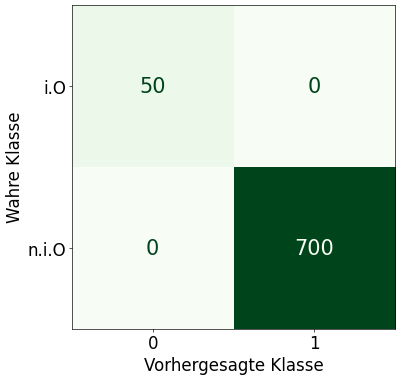

In [29]:
ch.plot_calc_cm(y_test0, y_pred0, class_name=["i.O", "n.i.O"], dpi=60)

In [34]:
def collect_results(clf, y_true, y_pred, algorithm, params, best_param):
    
    res = {"algorithm":algorithm, "params":params, "best_param":best_param,
           "rec_0":None, "pre_0":None, "f1_0":None, "rec_weighted":None, "pre_weighted":None, "f1_weighted":None, "acc":None}
    
    y_true0 = ch.swap_zero_one(y_true, 0)
    y_pred0 = ch.swap_zero_one(y_pred, 0)
    
    res["rec_0"] = recall_score(y_true0, y_pred0)
    res["pre_0"] = precision_score(y_true0, y_pred0)
    res["f1_0"] = f1_score(y_true0, y_pred0)
    res["rec_weighted"]= recall_score(y_true, y_pred, average='weighted')
    res["f1_weighted"]= f1_score(y_true, y_pred, average='weighted')
    res["pre_weighted"]= precision_score(y_true, y_pred, average='weighted')
    res["acc"] = accuracy_score(y_true, y_pred)
    
    for val in res.keys():
        if res[val]==None:
            print("somethong is wrong")
    
    return res

In [39]:
res = collect_results(best_clf, y_test, y_pred, algorithm="gradientboost", params=parameters, best_param=best_clf.get_params)
res

{'algorithm': 'decisiontree',
 'params': {'classifier__criterion': ['squared_error', 'mse'],
  'classifier__learning_rate': [0.01, 0.05, 0.1],
  'classifier__n_estimators': [100, 150, 200],
  'classifier__max_depth': [20, 80, 200],
  'classifier__min_samples_split': [2, 4, 8],
  'classifier__max_features': ['sqrt', 'log2']},
 'best_param': <bound method MLClassifierBase.get_params of BinaryRelevance(classifier=GradientBoostingClassifier(criterion='mse',
                                                       max_depth=20,
                                                       max_features='sqrt',
                                                       min_samples_split=8,
                                                       n_estimators=200),
                 require_dense=[True, True])>,
 'rec_0': 1.0,
 'pre_0': 1.0,
 'f1_0': 1.0,
 'rec_weighted': 0.8933333333333333,
 'pre_weighted': 0.9748913306883719,
 'f1_weighted': 0.9298519341388264,
 'acc': 0.8386666666666667}

In [40]:
filename = "mlc_ml_br_hyperopt_results_v2.4.json"
key_algorithm = "gb"
hyperopt_result = res

In [111]:
if os.path.exists(f"results/{filename}") == False:
    with open(f"results/{filename}", "w") as f:
        json.dump({f"{key_algorithm}":hyperopt_result}, f)
        f.close()
else:
    with open(f"results/{filename}", "r") as f:
        data = json.load(f)
        data.update({f"{key_algorithm}":hyperopt_result})
        
    with open(f"results/{filename}", "w") as f:
        json.dump(data, f)
        f.close()